### Manipulation of Peaks de novo results of ETNP 2017 P2 samples LC-MS/MS data using python.

Starting with:

    Peaks de novo results (.csv) of PTM-optimized database searches

Goal:

    Files with stripped (no PTMs) peptide lists and
    Columns with #'s of each modification in every sequence
    Column with stripped peptide lengths (# amino acids)
    
### To use:

#### 1. Change the input file name in *IN 4*
#### 2. Change output file name in *IN 6*, *IN 7*, *IN 8*

We don't have technical duplicates here, sadly, unlike the MED4 Pro samples. I exported PeaksDN search results CSVs into my ETNP 2017 git repo:

In [1]:
cd /home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/ETNP-SKQ17/PEAKS-PTMopt/

/home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/ETNP-SKQ17/PEAKS-PTMopt


In [2]:
ls

ETNP-SKQ17-231-100m-0.3-JA2_DN50.csv
ETNP-SKQ17-231-100m-0.3-JA2_DN50_ptm.csv
ETNP-SKQ17-231-100m-0.3-JA2_DN50_stripped_peptides.fas
ETNP-SKQ17-231-100m-0.3-JA2_DN50_stripped_peptides.txt
ETNP-SKQ17-231-100m-0.3-JA2_DN80_stripped_peptides.fas
ETNP-SKQ17-231-100m-0.3-JA2_DN80_stripped_peptides.txt
ETNP-SKQ17-233-265m-0.3-JA2_DN50_stripped.csv
ETNP-SKQ17-233-265m-0.3-JA4_DN50.csv
ETNP-SKQ17-233-265m-0.3-JA4_DN50_ptm.csv
ETNP-SKQ17-233-265m-0.3-JA4_DN50_stripped.csv
ETNP-SKQ17-233-265m-0.3-JA4_DN50_stripped_peptides.txt
ETNP-SKQ17-233-265m-0.3-JA4_DN50_totals.csv
ETNP-SKQ17-243-965m-0.3-JA14_DN50.csv
ETNP-SKQ17-243-965m-0.3-JA14_DN50_ptm.csv
ETNP-SKQ17-243-965m-0.3-JA14_DN50_stripped.csv
ETNP-SKQ17-243-965m-0.3-JA14_DN50_stripped_peptides.txt
ETNP-SKQ17-243-965m-0.3-JA14_DN80_stripped_peptides.txt
ETNP-SKQ17-273-965m-trap_DN50.csv
ETNP-SKQ17-273-965m-trap_DN50_ptm.csv
ETNP-SKQ17-273-965m-trap_DN50_stripped.csv
ETNP-SKQ17-273-965m-trap_DN50_stripped_peptides.txt
ETNP-SKQ17-273-965m-trap_DN

In [3]:
# LIBRARIES
#import pandas library for working with tabular data
import os
os.getcwd()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kde
#import regular expresson (regex)
import re
#check pandas version
pd.__version__

'1.0.5'

## 231: 100 m McLane pump filtered on 0.3 um GF-75

In [4]:
#read the CSV into a datadrame we name 'comet' using the pandas read_csv function
peaks = pd.read_csv("/home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/ETNP-SKQ17/PEAKS-PTMopt/ETNP-SKQ17-231-100m-0.3-JA2_DN50.csv")


#look at the dataframe
peaks.head()

,Fraction,Scan,Source File,Peptide,Tag Length,ALC (%),length,m/z,z,RT,Area,Mass,ppm,PTM,local confidence (%),tag (>=0%),mode
0,1,14924,20170410_ETNP-231-100m-0.3um-JA2_01.raw,EN(+.98)LAALEK,8,98,8,444.7382,2,50.59,38500000.0,887.4600,2.0,Deamidation (NQ),98 99 100 99 98 99 100 96,EN(+.98)LAALEK,CID
1,1,11873,20170410_ETNP-231-100m-0.3um-JA2_01.raw,EN(+.98)N(+.98)LLAK,7,98,7,402.2114,2,41.36,7910000.0,802.4072,1.2,Deamidation (NQ),97 98 97 98 99 99 99,EN(+.98)N(+.98)LLAK,CID
2,1,16508,20170410_ETNP-231-100m-0.3um-JA2_01.raw,TGN(+.98)FLDPK,8,98,8,446.7253,2,55.16,5860000.0,891.4338,2.6,Deamidation (NQ),94 97 99 99 99 99 99 98,TGN(+.98)FLDPK,CID
3,1,27852,20170410_ETNP-231-100m-0.3um-JA2_01.raw,WLVNHPR,7,97,7,461.2513,2,81.49,1550000.0,920.4980,-10.8,NaN,99 100 100 96 97 97 98,WLVNHPR,CID
4,1,15671,20170410_ETNP-231-100m-0.3um-JA2_01.raw,TDENLPLGPK,10,97,10,542.2884,2,52.76,10900000.0,1082.5608,1.3,NaN,98 99 100 99 100 97 98 95 98 95,TDENLPLGPK,CID


In [5]:
# use a count function to enumerate the # of A's (alanines) in each peptide
peaks['A'] = peaks['Peptide'].str.count("A")

# use a count function to enumerate the # of C's (cysteines) in each peptide
peaks['C'] = peaks['Peptide'].str.count("C")

# use a count function to enumerate the # of D's (aspartic acids) in each peptide
peaks['D'] = peaks['Peptide'].str.count("D")

# use a count function to enumerate the # of E's (glutamic acids) in each peptide
peaks['E'] = peaks['Peptide'].str.count("E")

# use a count function to enumerate the # of F's (phenylalanines) in each peptide
peaks['F'] = peaks['Peptide'].str.count("F")

# use a count function to enumerate the # of G's (glycines) in each peptide
peaks['G'] = peaks['Peptide'].str.count("G")

# use a count function to enumerate the # of H's (histidines) in each peptide
peaks['H'] = peaks['Peptide'].str.count("H")

# use a count function to enumerate the # of I's (isoleucines) in each peptide
# in PEAKS output, there will be no isoleucines (they're lumped in with leucines)
peaks['I'] = peaks['Peptide'].str.count("I")

# use a count function to enumerate the # of K's (lysines) in each peptide
peaks['K'] = peaks['Peptide'].str.count("K")

# use a count function to enumerate the # of L's (leucines) in each peptide
peaks['L'] = peaks['Peptide'].str.count("L")

# use a count function to enumerate the # of M's (methionines) in each peptide
peaks['M'] = peaks['Peptide'].str.count("M")

# use a count function to enumerate the # of N's (asparagines) in each peptide
peaks['N'] = peaks['Peptide'].str.count("N")

# use a count function to enumerate the # of P's ([prolines]) in each peptide
peaks['P'] = peaks['Peptide'].str.count("P")

# use a count function to enumerate the # of Q's (glutamines) in each peptide
peaks['Q'] = peaks['Peptide'].str.count("Q")

# use a count function to enumerate the # of R's (arginines) in each peptide
peaks['R'] = peaks['Peptide'].str.count("R")

# use a count function to enumerate the # of S's (serines) in each peptide
peaks['S'] = peaks['Peptide'].str.count("S")

# use a count function to enumerate the # of T's (threonines) in each peptide
peaks['T'] = peaks['Peptide'].str.count("T")

# use a count function to enumerate the # of V's (valines) in each peptide
peaks['V'] = peaks['Peptide'].str.count("V")

# use a count function to enumerate the # of W's (tryptophans) in each peptide
peaks['W'] = peaks['Peptide'].str.count("W")

# use a count function to enumerate the # of Y's (tyrosines) in each peptide
peaks['Y'] = peaks['Peptide'].str.count("Y")

# use a count function to enumerate the # of carbamidomethylated C's in each peptide
peaks['c-carb'] = peaks['Peptide'].str.count("57.02")

# use a count function to enumerate the # of oxidized M's in each peptide
peaks['m-oxid'] = peaks['Peptide'].apply(lambda x: x.count('M(+15.99)'))

# use a lamba function to enumerate the # of deamidated N's in each peptide
# used to use peaks['n-deam'] = peaks['Peptide'].str.count("N\(+.98") but that didn't work with the 'N'

peaks['n-deam'] = peaks['Peptide'].apply(lambda x: x.count('N(+.98)'))

# use a count function to enumerate the # of deamidated Q's in each peptide
peaks['q-deam'] = peaks['Peptide'].apply(lambda x: x.count('Q(+.98)'))

# use a count function to enumerate the # of hydroxylated K's in each peptide
peaks['k-hydr'] = peaks['Peptide'].apply(lambda x: x.count('K(+15.99)'))

# use a count function to enumerate the # of hydroxylated P's in each peptide
peaks['p-hydr'] = peaks['Peptide'].apply(lambda x: x.count('P(+15.99)'))

# use a count function to enumerate the # of methylated K's in each peptide
peaks['k-meth'] = peaks['Peptide'].apply(lambda x: x.count('K(+14.02)'))

# use a count function to enumerate the # of methylated R's in each peptide
peaks['r-meth'] = peaks['Peptide'].apply(lambda x: x.count('R(+14.02)'))

# create a column with 'stripped' peptide sequences using strip
peaks['stripped peptide'] = peaks['Peptide'].str.replace(r"\(.*\)","")

# add a column with the stripped peptide length (number of AAs)
peaks['stripped length'] = peaks['stripped peptide'].apply(len)

# total the number of modifications in sequence
peaks['ptm-total'] = peaks['c-carb'] + peaks['m-oxid'] + peaks['n-deam'] + peaks['q-deam'] + peaks['k-hydr'] + peaks['p-hydr'] + peaks['k-meth'] + peaks['r-meth']

# total the number of modifications in sequence relative to # of AAs
peaks['ptm-norm'] = peaks['ptm-total'] / peaks['stripped length']

# write modified dataframe to new txt file, same name + 'stripped'
peaks.to_csv("/home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/ETNP-SKQ17/PEAKS-PTMopt/ETNP-SKQ17-231-100m-0.3-JA2_DN50_stripped.csv")


# check out the results
peaks.head(10)

,Fraction,Scan,Source File,Peptide,Tag Length,ALC (%),length,m/z,z,RT,...,n-deam,q-deam,k-hydr,p-hydr,k-meth,r-meth,stripped peptide,stripped length,ptm-total,ptm-norm
0,1,14924,20170410_ETNP-231-100m-0.3um-JA2_01.raw,EN(+.98)LAALEK,8,98,8,444.7382,2,50.59,...,1,0,0,0,0,0,ENLAALEK,8,1,0.125000
1,1,11873,20170410_ETNP-231-100m-0.3um-JA2_01.raw,EN(+.98)N(+.98)LLAK,7,98,7,402.2114,2,41.36,...,2,0,0,0,0,0,ENLLAK,6,2,0.333333
2,1,16508,20170410_ETNP-231-100m-0.3um-JA2_01.raw,TGN(+.98)FLDPK,8,98,8,446.7253,2,55.16,...,1,0,0,0,0,0,TGNFLDPK,8,1,0.125000
3,1,27852,20170410_ETNP-231-100m-0.3um-JA2_01.raw,WLVNHPR,7,97,7,461.2513,2,81.49,...,0,0,0,0,0,0,WLVNHPR,7,0,0.000000
4,1,15671,20170410_ETNP-231-100m-0.3um-JA2_01.raw,TDENLPLGPK,10,97,10,542.2884,2,52.76,...,0,0,0,0,0,0,TDENLPLGPK,10,0,0.000000
5,1,11157,20170410_ETNP-231-100m-0.3um-JA2_01.raw,LNEGFDR,7,97,7,425.7072,2,39.24,...,0,0,0,0,0,0,LNEGFDR,7,0,0.000000
6,1,21773,20170410_ETNP-231-100m-0.3um-JA2_01.raw,EN(+.98)LGFLEK,8,97,8,475.7465,2,68.71,...,1,0,0,0,0,0,ENLGFLEK,8,1,0.125000
7,1,14767,20170410_ETNP-231-100m-0.3um-JA2_01.raw,TTLLYR,6,97,6,383.7273,2,50.17,...,0,0,0,0,0,0,TTLLYR,6,0,0.000000
8,1,28785,20170410_ETNP-231-100m-0.3um-JA2_01.raw,VNLWQWK,7,97,7,487.2672,2,83.41,...,0,0,0,0,0,0,VNLWQWK,7,0,0.000000
9,1,15846,20170410_ETNP-231-100m-0.3um-JA2_01.raw,TSNFLDPK,8,97,8,461.2381,2,53.27,...,0,0,0,0,0,0,TSNFLDPK,8,0,0.000000


In [6]:
# made a new dataframe that contains the sums of certain columns in the stripped peptide dataframe above

index = ['sample total']

data = {'A': peaks['A'].sum(),
        'C': peaks['C'].sum(),
        'D': peaks['D'].sum(),
        'E': peaks['E'].sum(),
        'F': peaks['F'].sum(),
        'G': peaks['G'].sum(),
        'H': peaks['H'].sum(),
        'I': peaks['I'].sum(),
        'K': peaks['K'].sum(),
        'L': peaks['L'].sum(),
        'M': peaks['M'].sum(),
        'N': peaks['N'].sum(),
        'P': peaks['P'].sum(),
        'Q': peaks['Q'].sum(),
        'R': peaks['R'].sum(),
        'S': peaks['S'].sum(),
        'T': peaks['T'].sum(),
        'V': peaks['V'].sum(),
        'W': peaks['W'].sum(),
        'Y': peaks['Y'].sum(),
        'c-carb': peaks['c-carb'].sum(),
        'm-oxid': peaks['m-oxid'].sum(),
        'n-deam': peaks['n-deam'].sum(),
        'q-deam': peaks['q-deam'].sum(),
        'k-hydr': peaks['k-hydr'].sum(),
        'p-hydr': peaks['p-hydr'].sum(),
        'k-meth': peaks['k-meth'].sum(),
        'r-meth': peaks['r-meth'].sum()
       }

totalpeaks = pd.DataFrame(data, columns=['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', 'c-carb', 'm-oxid', 'n-deam', 'q-deam', 'k-hydr', 'p-hydr', 'k-meth', 'r-meth' ], index=index)

# calculate percentage of C's with carb (should be 1.0)
totalpeaks['% C w/ carb.'] = totalpeaks['c-carb'] / totalpeaks['C'] 

# calculate percentage of M's that are oxidized
totalpeaks['% M w/ oxid'] = totalpeaks['m-oxid'] / totalpeaks['M'] 

# calculate percentage of N's that are deamidated
totalpeaks['% N w/ deam'] = totalpeaks['n-deam'] / totalpeaks['N'] 

# calculate percentage of Q's that are deamidated
totalpeaks['% Q w/ deam'] = totalpeaks['q-deam'] / totalpeaks['Q'] 

# calculate percentage of K's that are hydroxylated
totalpeaks['% K w/ hydr'] = totalpeaks['k-hydr'] / totalpeaks['K'] 

# calculate percentage of P's that are hydroxylated
totalpeaks['% P w/ hydr'] = totalpeaks['p-hydr'] / totalpeaks['P'] 

# calculate percentage of K's that are methylated
totalpeaks['% K w/ meth'] = totalpeaks['k-meth'] / totalpeaks['K'] 

# calculate percentage of R's that are methylated
totalpeaks['% R w/ meth'] = totalpeaks['r-meth'] / totalpeaks['R'] 

# write modified dataframe to new txt file, same name + 'stripped'
totalpeaks.to_csv("/home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/ETNP-SKQ17/PEAKS-PTMopt/ETNP-SKQ17-231-100m-0.3-JA2_DN50_totals.csv")

totalpeaks.head()

,A,C,D,E,F,G,H,I,K,L,...,k-meth,r-meth,% C w/ carb.,% M w/ oxid,% N w/ deam,% Q w/ deam,% K w/ hydr,% P w/ hydr,% K w/ meth,% R w/ meth
sample total,3927,626,2010,2762,1551,2101,1048,0,5403,4784,...,796,1047,1.0,0.43424,0.202742,0.029278,0.135665,0.389918,0.147326,0.287637


### Visualizing the results

In [7]:
print("ALC max: ", peaks['ALC (%)'].max())
print("ALC min: ", peaks['ALC (%)'].min())

ALC max:  98
ALC min:  50


In [8]:
# take only AA totals and transpose for easier bar plotting in matplotlib

peaksaatot = totalpeaks[['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']].copy().T

# take only AA %s and transpose for easier bar plotting in matplotlib

peaksreltot = totalpeaks[['% C w/ carb.', '% M w/ oxid', '% N w/ deam', '% Q w/ deam', '% K w/ hydr', '% P w/ hydr', '% K w/ meth', '% R w/ meth']].copy().T

[Text(0, 0, 'sample total')]

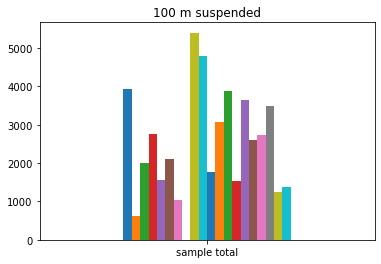

In [9]:
# bar plot of residue totals
# there is no isoleucine (I) in Peaks data, which is why L is really big and I is 0


x_labels = ['sample total']

ax = totalpeaks.plot(y=['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'], kind="bar", title = '100 m suspended')
plt.xticks(rotation=0)
ax.get_legend().remove()
ax.set_xticklabels(x_labels)

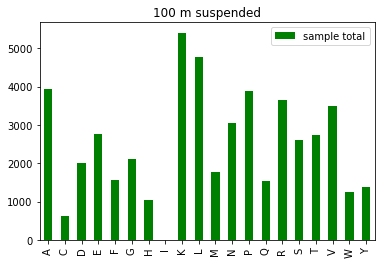

In [10]:
# bar plot of residue totals
# there is no isoleucine (I) in Peaks data, which is why L is really big and I is 0

my_colors = [(x/10.0, x/20.0, 0.75) for x in range(len(peaksaatot))] # <-- Quick gradient example along the Red/Green dimensions.

ax = peaksaatot.plot(y=['sample total'], kind="bar", color = 'green', title = '100 m suspended')


[]

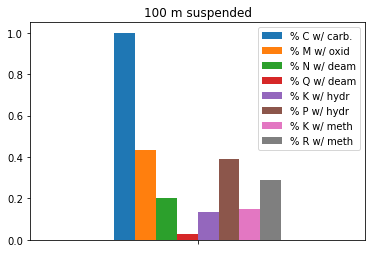

In [11]:
# bar plot of relative modifications

ax = totalpeaks.plot(y=['% C w/ carb.', '% M w/ oxid', '% N w/ deam', '% Q w/ deam', '% K w/ hydr', '% P w/ hydr', '% K w/ meth', '% R w/ meth'], kind="bar", title = '100 m suspended')
ax.set_xticklabels([])

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text major ticklabel objects>)

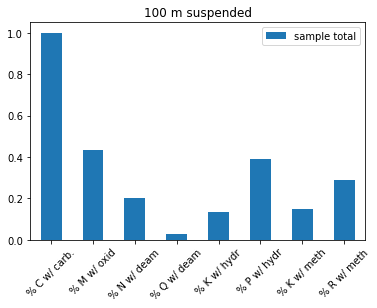

In [12]:
# bar plot of relative mods


ax = peaksreltot.plot(y=['sample total'], kind="bar", title = '100 m suspended')
plt.xticks(rotation=45)

Text(0.5, 1.0, 'Arginine methylation')

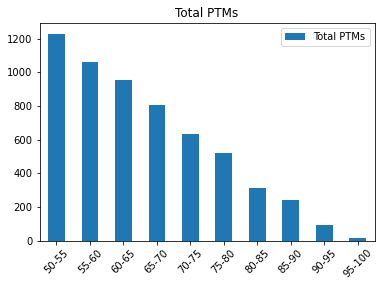

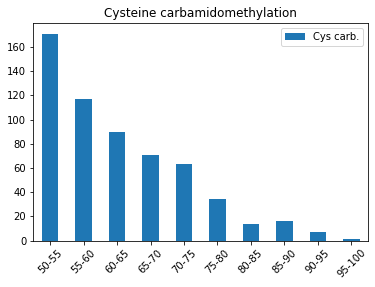

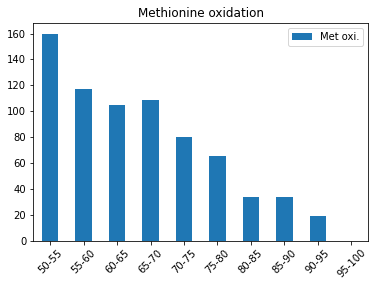

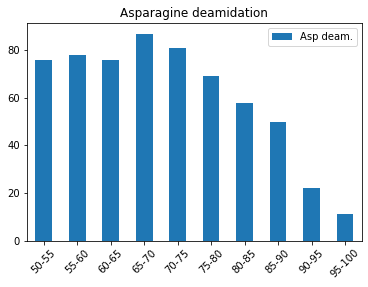

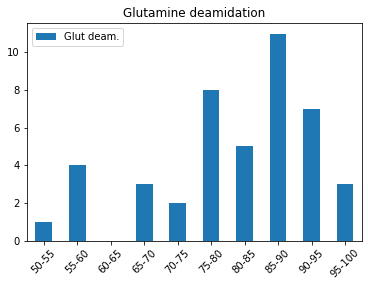

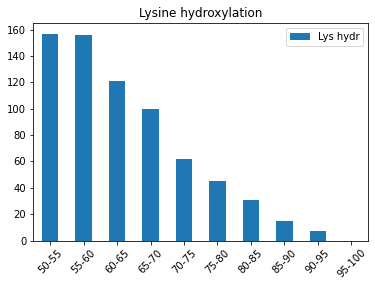

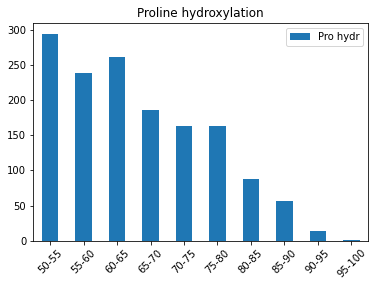

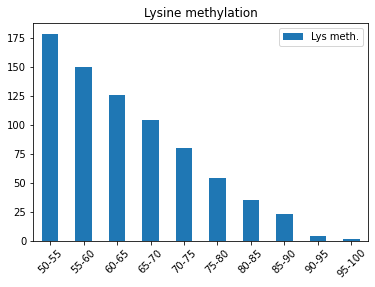

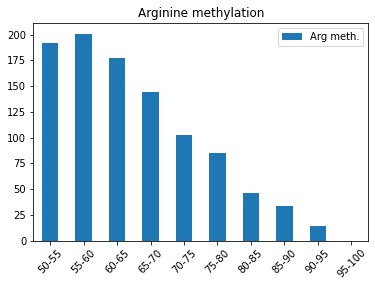

In [13]:
# making evenly spaced bins for the ALC data based on the min and max, called above
bins = [50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
labels = ['50-55', '55-60', '60-65', '65-70', '70-75', '75-80', '80-85', '85-90', '90-95', '95-100']

# use pandas cut function to do the binning itself
peaks['binned'] = pd.cut(peaks['ALC (%)'], bins=bins, labels=labels)

# bar plots of binned PTM data

index = ['50-55', '55-60', '60-65', '65-70', '70-75', '75-80', '80-85', '85-90', '90-95', '95-100']
data = {'Total PTMs': [peaks.groupby('binned')['ptm-total'].sum()['50-55'], peaks.groupby('binned')['ptm-total'].sum()['55-60'], peaks.groupby('binned')['ptm-total'].sum()['60-65'], peaks.groupby('binned')['ptm-total'].sum()['65-70'], peaks.groupby('binned')['ptm-total'].sum()['70-75'], peaks.groupby('binned')['ptm-total'].sum()['75-80'], peaks.groupby('binned')['ptm-total'].sum()['80-85'], peaks.groupby('binned')['ptm-total'].sum()['85-90'], peaks.groupby('binned')['ptm-total'].sum()['90-95'], peaks.groupby('binned')['ptm-total'].sum()['95-100']],
        'Cys carb.': [peaks.groupby('binned')['c-carb'].sum()['50-55'], peaks.groupby('binned')['c-carb'].sum()['55-60'], peaks.groupby('binned')['c-carb'].sum()['60-65'], peaks.groupby('binned')['c-carb'].sum()['65-70'], peaks.groupby('binned')['c-carb'].sum()['70-75'], peaks.groupby('binned')['c-carb'].sum()['75-80'], peaks.groupby('binned')['c-carb'].sum()['80-85'], peaks.groupby('binned')['c-carb'].sum()['85-90'], peaks.groupby('binned')['c-carb'].sum()['90-95'], peaks.groupby('binned')['c-carb'].sum()['95-100']],
        'Met oxi.': [peaks.groupby('binned')['m-oxid'].sum()['50-55'], peaks.groupby('binned')['m-oxid'].sum()['55-60'], peaks.groupby('binned')['m-oxid'].sum()['60-65'], peaks.groupby('binned')['m-oxid'].sum()['65-70'], peaks.groupby('binned')['m-oxid'].sum()['70-75'], peaks.groupby('binned')['m-oxid'].sum()['75-80'], peaks.groupby('binned')['m-oxid'].sum()['80-85'], peaks.groupby('binned')['m-oxid'].sum()['85-90'], peaks.groupby('binned')['m-oxid'].sum()['90-95'], peaks.groupby('binned')['m-oxid'].sum()['95-100']],
        'Asp deam.': [peaks.groupby('binned')['n-deam'].sum()['50-55'], peaks.groupby('binned')['n-deam'].sum()['55-60'], peaks.groupby('binned')['n-deam'].sum()['60-65'], peaks.groupby('binned')['n-deam'].sum()['65-70'], peaks.groupby('binned')['n-deam'].sum()['70-75'], peaks.groupby('binned')['n-deam'].sum()['75-80'], peaks.groupby('binned')['n-deam'].sum()['80-85'], peaks.groupby('binned')['n-deam'].sum()['85-90'], peaks.groupby('binned')['n-deam'].sum()['90-95'], peaks.groupby('binned')['n-deam'].sum()['95-100']],
        'Glut deam.': [peaks.groupby('binned')['q-deam'].sum()['50-55'], peaks.groupby('binned')['q-deam'].sum()['55-60'], peaks.groupby('binned')['q-deam'].sum()['60-65'], peaks.groupby('binned')['q-deam'].sum()['65-70'], peaks.groupby('binned')['q-deam'].sum()['70-75'], peaks.groupby('binned')['q-deam'].sum()['75-80'], peaks.groupby('binned')['q-deam'].sum()['80-85'], peaks.groupby('binned')['q-deam'].sum()['85-90'], peaks.groupby('binned')['q-deam'].sum()['90-95'], peaks.groupby('binned')['q-deam'].sum()['95-100']],
        'Lys hydr': [peaks.groupby('binned')['k-hydr'].sum()['50-55'], peaks.groupby('binned')['k-hydr'].sum()['55-60'], peaks.groupby('binned')['k-hydr'].sum()['60-65'], peaks.groupby('binned')['k-hydr'].sum()['65-70'], peaks.groupby('binned')['k-hydr'].sum()['70-75'], peaks.groupby('binned')['k-hydr'].sum()['75-80'], peaks.groupby('binned')['k-hydr'].sum()['80-85'], peaks.groupby('binned')['k-hydr'].sum()['85-90'], peaks.groupby('binned')['k-hydr'].sum()['90-95'], peaks.groupby('binned')['k-hydr'].sum()['95-100']],
        'Pro hydr': [peaks.groupby('binned')['p-hydr'].sum()['50-55'], peaks.groupby('binned')['p-hydr'].sum()['55-60'], peaks.groupby('binned')['p-hydr'].sum()['60-65'], peaks.groupby('binned')['p-hydr'].sum()['65-70'], peaks.groupby('binned')['p-hydr'].sum()['70-75'], peaks.groupby('binned')['p-hydr'].sum()['75-80'], peaks.groupby('binned')['p-hydr'].sum()['80-85'], peaks.groupby('binned')['p-hydr'].sum()['85-90'], peaks.groupby('binned')['p-hydr'].sum()['90-95'], peaks.groupby('binned')['p-hydr'].sum()['95-100']],
        'Lys meth.': [peaks.groupby('binned')['k-meth'].sum()['50-55'], peaks.groupby('binned')['k-meth'].sum()['55-60'], peaks.groupby('binned')['k-meth'].sum()['60-65'], peaks.groupby('binned')['k-meth'].sum()['65-70'], peaks.groupby('binned')['k-meth'].sum()['70-75'], peaks.groupby('binned')['k-meth'].sum()['75-80'], peaks.groupby('binned')['k-meth'].sum()['80-85'], peaks.groupby('binned')['k-meth'].sum()['85-90'], peaks.groupby('binned')['k-meth'].sum()['90-95'], peaks.groupby('binned')['k-meth'].sum()['95-100']],
        'Arg meth.': [peaks.groupby('binned')['r-meth'].sum()['50-55'], peaks.groupby('binned')['r-meth'].sum()['55-60'], peaks.groupby('binned')['r-meth'].sum()['60-65'], peaks.groupby('binned')['r-meth'].sum()['65-70'], peaks.groupby('binned')['r-meth'].sum()['70-75'], peaks.groupby('binned')['r-meth'].sum()['75-80'], peaks.groupby('binned')['r-meth'].sum()['80-85'], peaks.groupby('binned')['r-meth'].sum()['85-90'], peaks.groupby('binned')['r-meth'].sum()['90-95'], peaks.groupby('binned')['r-meth'].sum()['95-100']]
        }

peaksbin = pd.DataFrame(data, columns=['Total PTMs','Cys carb.','Met oxi.','Asp deam.', 'Glut deam.', 'Lys hydr', 'Pro hydr', 'Lys meth.', 'Arg meth.'], index=index)

# write the peaks bin ptm dataframe to a csv:
peaksbin.to_csv("/home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/ETNP-SKQ17/PEAKS-PTMopt/ETNP-SKQ17-231-100m-0.3-JA2_DN50_ptm.csv")

ax1 = peaksbin.plot.bar(y='Total PTMs', rot=45)
ax1.set_title('Total PTMs')

ax2 = peaksbin.plot.bar(y='Cys carb.', rot=45)
ax2.set_title('Cysteine carbamidomethylation')

ax3 = peaksbin.plot.bar(y='Met oxi.', rot=45)
ax3.set_title('Methionine oxidation')

ax4 = peaksbin.plot.bar(y='Asp deam.', rot=45)
ax4.set_title('Asparagine deamidation')

ax5 = peaksbin.plot.bar(y='Glut deam.', rot=45)
ax5.set_title('Glutamine deamidation')

ax6 = peaksbin.plot.bar(y='Lys hydr', rot=45)
ax6.set_title('Lysine hydroxylation')

ax7 = peaksbin.plot.bar(y='Pro hydr', rot=45)
ax7.set_title('Proline hydroxylation')

ax8 = peaksbin.plot.bar(y='Lys meth.', rot=45)
ax8.set_title('Lysine methylation')

ax9 = peaksbin.plot.bar(y='Arg meth.', rot=45)
ax9.set_title('Arginine methylation')


### Exporting txt files of stripped peptides at confidence cutoffs:

In [ ]:
# keep only peptide column >50% ALC
pep = peaks[["stripped peptide"]]

# write altered dataframe to new txt file
# used header and index parameters to get rid of 'Peptide' header and the indexing

pep.to_csv("/home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/ETNP-SKQ17/PEAKS-PTMopt/ETNP-SKQ17-231-100m-0.3-JA2_DN50_stripped_peptides.txt", header=False, index=False)

# made the text file into a FASTA 

!awk '{print ">"NR"\n"$0}' /home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/ETNP-SKQ17/PEAKS-PTMopt/ETNP-SKQ17-231-100m-0.3-JA2_DN50_stripped_peptides.txt > /home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/ETNP-SKQ17/PEAKS-PTMopt/ETNP-SKQ17-231-100m-0.3-JA2_DN50_stripped_peptides.fas

# look

print("# of DN peptide >50% ALC", len(pep))
pep.head()

In [ ]:
# keep only peptides  >80% ALC
peaks80 = peaks.loc[peaks['ALC (%)'] >= 80]

# see how many rows and double check
# peaks80.head(-10)

# keep only peptide column 
pep80 = peaks80[["stripped peptide"]]

# write altered dataframe to new txt file
# used header and index parameters to get rid of 'Peptide' header and the indexing

pep80.to_csv("/home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/ETNP-SKQ17/PEAKS-PTMopt/ETNP-SKQ17-231-100m-0.3-JA2_DN80_stripped_peptides.txt", header=False, index=False)

# made the text file into a FASTA 

!awk '{print ">"NR"\n"$0}' /home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/ETNP-SKQ17/PEAKS-PTMopt/ETNP-SKQ17-231-100m-0.3-JA2_DN80_stripped_peptides.txt > /home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/ETNP-SKQ17/PEAKS-PTMopt/ETNP-SKQ17-231-100m-0.3-JA2_DN80_stripped_peptides.fas

print("# of DN peptide >80% ALC", len(pep80))
pep80.head()

### Using BioPython to query peptide sequences

I installed the BioPython package using `pip install biopython`. All instructions and information [here](https://www.tutorialspoint.com/biopython/index.htm). 

GitHub project: https://github.com/biopython/biopython

I'm relying on the ProtParam module to parse sequences for relative AA composition, instability, secondary structure, instability, and hydrophobicity. You can read more about that module and the studies the indecies are derived from here:

https://biopython.org/wiki/ProtParam

In [ ]:
# Bio.SeqIO is the standard Sequence Input/Output interface for BioPython 1.43 and later
# Bio.SeqIO provides a simple uniform interface to input and output assorted sequence file formats.
# (including multiple sequence alignments), but will only deal with sequences as SeqRecord objects

# for accepted file formats see https://biopython.org/wiki/SeqIO

from Bio import SeqIO
#for seq_record in SeqIO.parse("/home/millieginty/Documents/git-repos/2017-etnp/data/MED4/MED2_tryp_1raw_db_peptides_nmod.fasta", "fasta"):
    #print(seq_record.id)
    #print(repr(seq_record.seq))
    #print(len(seq_record))
    
# I commented the print functions out so the output doesn't take up too much space. 

In [ ]:
# seeing what the ProtParam module can do with a single protein sequence:

from Bio.SeqUtils.ProtParam import ProteinAnalysis

test_seq = "MAEGEITTFTALTEKFNLPPGNYKKPKLLYCSNGGHFLRILPDGTVDGTRDRSDQHIQLQLSAESVGEVYIKSTETGQYLAMDTSGLLYGSQTPSEECLFLERLEENHYNTYTSKKHAEKNWFVGLKKNGSCKRGPRTHYGQKAILFLPLPV"

analysed_seq = ProteinAnalysis(test_seq)
print("molecular weight of seq =", analysed_seq.molecular_weight())

# calculates the aromaticity value of a protein according to Lobry & Gautier (1994, Nucleic Acids Res., 22, 3174-3180). 
# it's simply the relative frequency of Phe+Trp+Tyr.

analysed_seq.aromaticity()
print("aromaticity of seq =", analysed_seq.aromaticity())

# secondary_structure_fraction:
# this methods returns a list of the fraction of amino acids which tend to be in helix, turn or sheet. 
# AAs in helix: V, I, Y, F, W, L
# AAs in turn: N, P, G, S
# AAs in sheet: E, M, A, L
# the returned list contains 3 values: [Helix, Turn, Sheet]

analysed_seq.secondary_structure_fraction()
print("frac in H T S =", analysed_seq.secondary_structure_fraction())

# the instability index, an implementation of the method of Guruprasad et al. (1990, Protein Engineering, 4, 155-161).
# this method tests a protein for stability. 
# any value above 40 means the protein is unstable (=has a short half life)
# NOT SURE WHAT THIS MEANS FOR PEPTIDES, BUT WE COULD DO THIS FOR PROTEINS

analysed_seq.instability_index()
print("instability =", analysed_seq.instability_index())

# count_amino_acids will do just that, and get_amino_acids_percent will return %'s for each AA across the sequence. 
analysed_seq.get_amino_acids_percent()

# taking the returned dictionary and converting to a dataframe

aadict = analysed_seq.get_amino_acids_percent()
aadf = pd.DataFrame(list(aadict.items()),columns = ['residue','% occurance']) 

aadf.head()

In [ ]:
# use SeqIO and a loop to apply count_amino_acids to each sequence in the file
# aatot will give us the total number of each residue in the entire sample output

import collections
from Bio import SeqIO
from Bio.SeqUtils.ProtParam import ProteinAnalysis

all_aas = collections.defaultdict(int)
for record in SeqIO.parse("/home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/ETNP-SKQ17/PEAKS-PTMopt/ETNP-SKQ17-231-100m-0.3-JA2_DN50_stripped_peptides.fas", "fasta"):
    x = ProteinAnalysis(str(record.seq))
    #print(record.id, x.count_amino_acids())
    for aa, count in x.count_amino_acids().items():
        all_aas[aa] += count        
        
# made a dataframe for amino acid total counts        
data = (all_aas)
aatot = pd.DataFrame(data, index = ['sample sequence total'])
aatot.head()

In [ ]:
from pandas import Series, DataFrame

with open('/home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/ETNP-SKQ17/PEAKS-PTMopt/ETNP-SKQ17-231-100m-0.3-JA2_DN50_stripped_peptides.fas') as fasta_file:  # Will close handle cleanly
    identifiers = []
    lengths = []
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
        identifiers.append(seq_record.id)
        lengths.append(len(seq_record.seq))
        
        
#converting lists to pandas Series    
s1 = Series(identifiers, name='ID')
s2 = Series(lengths, name='length')

#Gathering Series into a pandas DataFrame and rename index as ID column
idseq = DataFrame(dict(ID=s1, length=s2)).set_index(['ID'])

idseq.head()

In [ ]:
from pandas import Series, DataFrame



with open('/home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/ETNP-SKQ17/PEAKS-PTMopt/ETNP-SKQ17-231-100m-0.3-JA2_DN50_stripped_peptides.fas) as fasta_file:  # Will close handle cleanly
    identifiers = []
    lengths = []
    aa = []
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
        identifiers.append(seq_record.id)
        lengths.append(len(seq_record.seq))
        aa.count_amino_acids(seq_record.seq)
        
        
#converting lists to pandas Series    
s1 = Series(identifiers, name='ID')
s2 = Series(lengths, name='length')
s3 = Series(aa, name='AAs')

#Gathering Series into a pandas DataFrame and rename index as ID column
idseq = DataFrame(dict(ID=s1, length=s2, AAs=s3)).set_index(['ID'])

idseq.head()

In [ ]:
from Bio import SeqIO
from Bio.SeqUtils import ProtParam

handle = open("/home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/ETNP-SKQ17/PEAKS-PTMopt/ETNP-SKQ17-231-100m-0.3-JA2_DN50_stripped_peptides.fas") 
for record in SeqIO.parse(handle, "fasta"): 
    seq = str(record.seq)
    X = ProtParam.ProteinAnalysis(seq)
    print(X.count_amino_acids()) 
    #print X.get_amino_acids_percent() 
    #print X.molecular_weight() 
    #print X.aromaticity() 
    #print X.instability_index() 
    #print X.flexibility() 
    #print X.isoelectric_point() 
    #print X.secondary_structure_fraction()
    
# made a data series from the count_amino_acids function
# aacount = {X.count_amino_acids()}

# made a pandas dataframe from the series generated above
# aacount = pd.DataFrame(list(data.items()),columns = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']) 

aacount = pd.DataFrame(X.count_amino_acids(), index=[0])

# look at new dataframe

# aacount.head()